In [1]:
# ./src contains the module code which makes the jupyter notebook cleaner
import src.tools as tools
from src.protostar import Protostar

import matplotlib.pyplot as plt
import numpy as np

## Initializing Protostar object

The protostar object contains all the relevant information and data native to and calculate for the protostar. Details on the Protostar object, its attribute, and functions can been viewed in `protostar.py`

To initialize a protstar object, we need to provide the:
- Name of the star
- Coordinate of the star in pixels
- Directory to the catalogue containing all the protostars.

The code will initizalize an empty protostar object ready for us to use!

In [2]:
name = 'HOPS-250'
source_choord = (129.51569, 129.46035)
directory = '/Users/namsonnguyen/repo/data/protostars/'
my_star = Protostar(name, source_choord, directory)

# Creating shortcuts that point to the red and blue shifted outflow attributes of the protostar object
red = my_star.red_shifted
blue = my_star.blue_shifted

# This outflow dictionary will be useful for the for-loops we will use later on
outflows = {'red':red, 'blue':blue}

### Loading Data

With the object initialized, and our red and blue shifted outflows easily accessible in the dictionary, we can loop through each outflow and load in the image data.

The code runs a simple string parse statement to find the image data and loads it into the protostar object.

`color.image` now contains the raw image of the outflow and `color.header` contains the fits file header, where `color` is `red` or `blue`.

**Note**: The parsing script may need to be changed if there is a new naming scheme that does not match what I was working with at the time

In [3]:
uniform_path = 'image.moment.integrated.fits'

for color in my_star.colors:
    data_path = f'{directory}/{name}.{color}.{uniform_path}'
    outflows[color].image, outflows[color].header = tools._load_data(outflows[color], data_path)


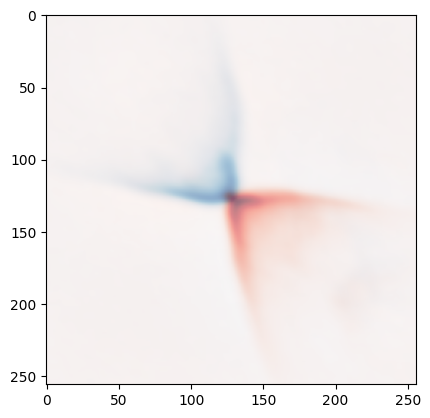

In [4]:
%matplotlib inline

plt.imshow(red.image, cmap='Reds')
plt.imshow(blue.image, cmap='Blues', alpha=0.5)

plt.show()

# Image Processing

Before we generate our edge detections, we need to process the image. There are generally three steps, one of which is optional:
1. Rotate image - rotate the image by eye so that it is oriented horizontally
2. Quartile clear - clear the adjacent side of the outflow that has emission we are not interested in
3. Lasso clean - based on analysis of the cube data, we can manually lasso out emission

The lasso clean step is used on a case by-case basis. The order in which these steps are executed are also on a case-by-case basis. Sometimes it is easier to rotate and quartile clear before using the lasso tool. Sometimes, it is easier to lasso clean the image before it is rotated.

Because of this, there are some manual edits that need to be done to the code in each step depending on the decided order.

### Rotate Image

Usually, I find that it is easiest to rotate the outflows first. This is simply done by manually providing an angle of rotation in the first line, where + is counter clockwise, - is clockwise

The code automatically rotates both outflows and plots the resulting rotated image allowing for easy tweaks.

**Note**: Rotate the image so that the **red outflow is on the left and the blue outflow is on the right**. The code will rely on this orientation to run properly.

**Bug**: Sometimes a certain angle would result in the image becoming "smeared". One way around it was to try different angles that sometimes would get rid of the effect. However, I have found the smearing did not have significant negative impacts on the results.

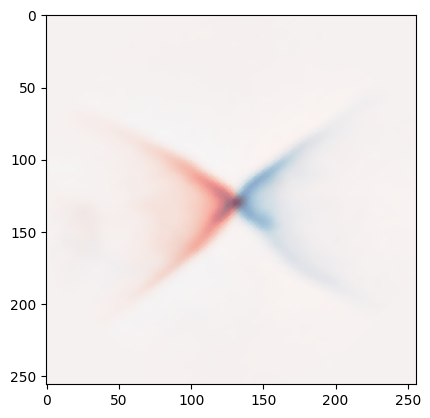

In [5]:
angle_rot = -133
images = [red.image, blue.image]

%matplotlib inline
for idx, color in enumerate(my_star.colors):
    cmap = color.capitalize() + 's'
    rotated_img = tools._rotate_outflow(outflows[color], images[idx], angle_rot)
    plt.imshow(outflows[color].image_rotated, cmap=cmap, alpha=1-0.5*idx)

plt.show()

### Quadrant Clearing

After the outflow images have been rotated, I clear the two quadrants that make up the side adjacent to the side with the outflow, where the origin is the protostar.

For example, for the red outflow, which is located on the left, the code will clear the 1st and 4th quadrant of all emission, setting it to the default `fill_val` = 0.

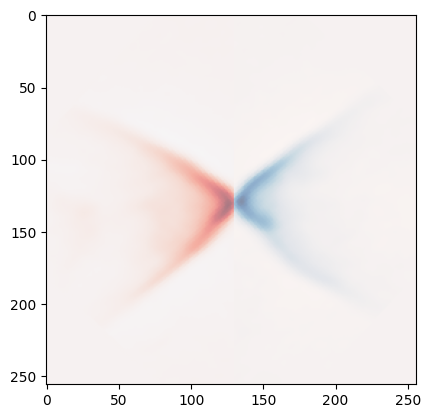

In [7]:
red.image_rotated = tools.fill_quadrant(red.image_rotated, quadrants=[1, 4], origin=my_star.source_coord)
blue.image_rotated = tools.fill_quadrant(blue.image_rotated, quadrants=[2, 3], origin=my_star.source_coord)

for idx, color in enumerate(my_star.colors):
    outflow = outflows[color]
    plt.imshow(outflow.image_rotated, alpha=1-0.5*idx, cmap=f'{color.capitalize()}s')

### Image Lasso Cleaning

If the outflow(s) still needs edits after it has been rotated and quadrant cleared, it can be manually edited using the lasso tool.

The code block requires some manual edits depending on which outflow we want to edit. The parameter we want to change is `outflow` and `image_to_lasso`.

The `image_to_lasso` parameter tells the lasso tool which image we want to lasso since there are three separate images that are saved in the protostar object:
1. image - the raw image loaded from the fits file without any edits whatsoever
2. image_rotated - the rotated image which contains the latest rotation
4. image_lasso - the lassoed image

If done in the default order of the notebook, no parameter edits are necessary. However, in the case one or two of the outflows need to be lassoed first, then `image_to_lasso` needs to be changed to `image` because the default `image_rotated` attribute has not yet been instantiated.

**Note**: The rotate and clear quadrant input parameters will need to be changed to `image_lasso` instead of the default `image`.

**None**: For this protostar, there is not a need to lasso, but it is done to illustrate how editing one outflow would require some manual changes. We can circle a blank area on the red outflow just to complete the lasso function without making actual changes to the image

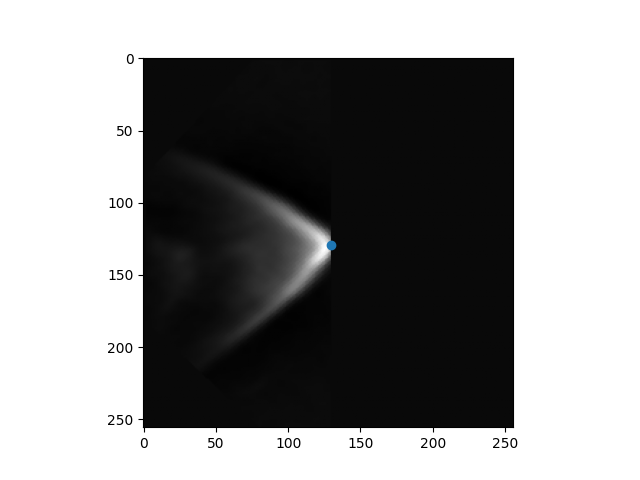

In [8]:
%matplotlib widget

# Parameters to change depending on situation
outflow = red
image_to_lasso = red.image_rotated

lasso_tool = tools.LassoTool(outflow, image_to_lasso)
outflow.image_lasso = lasso_tool.show()

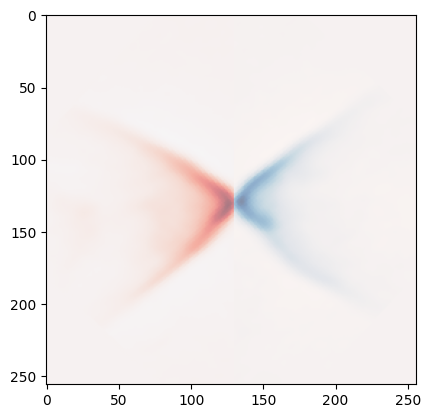

In [11]:
# The lassoed image is saved to the `image_lasso` attribute of the protostar object
outflow.image_lasso = tools.fill_quadrant(image_to_lasso, quadrants=[1, 4], origin=my_star.source_coord)

%matplotlib inline

# We save out finalized images to the `image_cleaned` attribute.
# Note that they are different because on was lassoed while the other was not
red.image_cleaned = red.image_lasso
blue.image_cleaned = blue.image_rotated

# The order for colors is red, then blue.
for idx, color in enumerate(my_star.colors):
    cmap = color.capitalize() + 's'
    if outflows[color].image_lasso is None:
        plt.imshow(outflows[color].image_cleaned, cmap=cmap, alpha=1-0.5*idx)
    else:
        plt.imshow(outflows[color].image_cleaned, cmap=cmap, alpha=1-0.5*idx)

# You may need to execute this cell twice to have the plot display properly
# This is a weird consequence of switching between %matplotlib widget and inline
plt.show()

# Find Mask Thresholds

### Find Largest Sigma Value

We need to find the maximum sigma value that provides the tightest mask for an edge detection that is accurate near the source, as well as the minimum sigma value that provides a looser mask for an edge detection that fits the extended lobes of the outflow.

The `_find_max_sigma_val()` function iterates through single increments of sigma values starting at 1. For each increment the function does the following:
1. Masks the outflow using the current iteration sigma value.
2. Generates an edge detection of the masked outflow image.
3. Checks the more extreme x-coordinate of the mask
    - if `red` then it is np.max(x)
    - if `blue` then it is np.min(x)
4. Check If the x-coordinate value is "beyond" the x-coordinate of the star
    - if `np.max(x) >= star x-coordinate`, max_sigma value not yet found
    - if `np.min(x) <= star x-coordinate`, max_sigma value not yet found
5. The function continues looping, increasing the sigma value until it finds a sigma that results in an edge detection that just touches the protostar.

This is the largest sigma value that results in an edge detection that accurately shapes the contour of the outflow at the source.

**Note**: Sometimes, the function will fail to find a resonable sigma value due to the emission level distribution. I've found that this occurs most commonly for outflows with very low emission or very uniform emission. If that is the case, then the largest sigma value must be found manually by eye. The `override_val` values can be used.

Because the max sigma value for the red outflow is not reasonable using the `_find_max_sigma_val()` function, we need to use an override value. 

In [12]:
override_val = [100, 102]
for idx, color in enumerate(my_star.colors):
    outflow = outflows[color]
    #outflow.max_sigma = tools._find_max_sigma_val(outflow, outflow.image_rotated)
    outflow.max_sigma = override_val[idx]

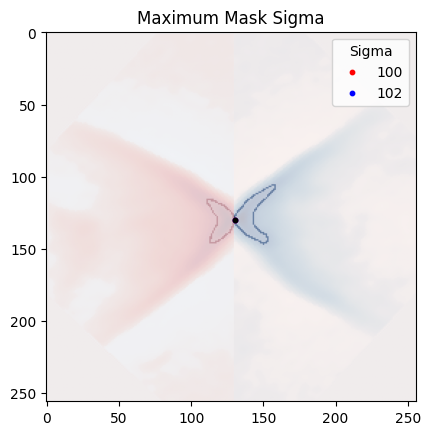

In [13]:
for idx, color in enumerate(my_star.colors):
    outflow = outflows[color]
    masked_img = tools._mask(outflow.image_rotated, outflow.max_sigma)
    edge = tools._detect_edge(masked_img)

    cmap = f'{color.capitalize()}s'
    alpha = 1-0.5*idx
    plt.imshow(edge, cmap=cmap, alpha=alpha)
    sqrt_img = np.sign(outflow.image_rotated)*np.sqrt(np.abs(outflow.image_rotated))
    plt.imshow(sqrt_img, cmap=cmap, alpha=alpha/2)
    plt.scatter(130, 130, c=outflow.color, s=10)

plt.scatter(130, 130, c='black', s=10)
plt.title('Maximum Mask Sigma')
plt.legend([red.max_sigma, blue.max_sigma], title='Sigma')


### Find Smallest Sigma Value

We can manually input different numbers to find the smallest reasonable sigma value. We want a resulting edge detection that does a good job tracing the extended contours of the lobe.

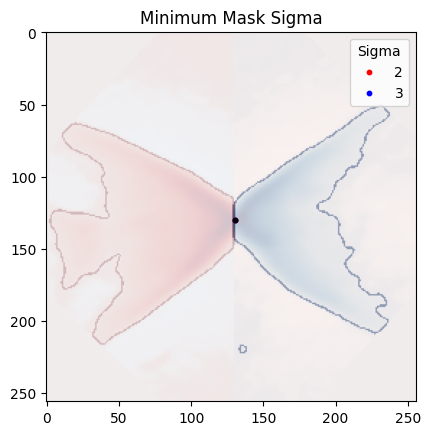

In [14]:
min_sigma = [2, 3]
for idx, color in enumerate(my_star.colors):
    outflow = outflows[color]
    outflow.min_sigma = min_sigma[idx]
    masked_img = tools._mask(outflow.image_rotated, min_sigma[idx])
    edge = tools._detect_edge(masked_img)

    cmap = f'{color.capitalize()}s'
    alpha = 1-0.5*idx
    plt.imshow(edge, cmap=cmap, alpha=alpha)
    sqrt_img = np.sign(outflow.image_rotated)*np.sqrt(np.abs(outflow.image_rotated))
    plt.imshow(sqrt_img, cmap=cmap, alpha=alpha/2)
    plt.scatter(130, 130, c=outflow.color, s=10)

plt.scatter(130, 130, c='black', s=10)
plt.title('Minimum Mask Sigma')
plt.legend([red.min_sigma, blue.min_sigma], title='Sigma')

# Detect Edges

Now that we have our two min/max sigma values, we can generate out edge detections.

Three edge detections are made:
1. The loose edge detection which uses the lowest sigma value
2. The tight edge detection which uses the highest sigma value
3. The transition edge detection which uses the average sigma value

This part is fully automatic and only requires us to execute it.

Text(0.5, 1.0, 'Outflow Contours')

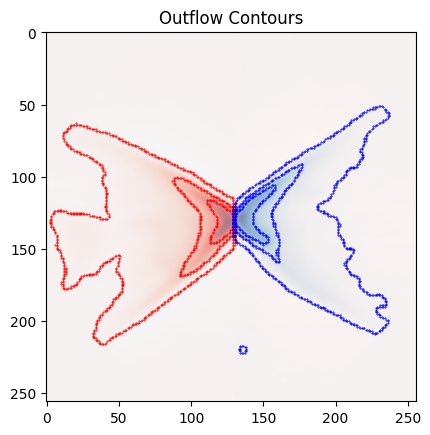

In [15]:
for idx, color in enumerate(my_star.colors):
    outflow = outflows[color]
    sigmas = np.linspace(outflow.min_sigma, outflow.max_sigma, 3)
    edges = []
    for sigma in sigmas:
        edges.append(tools._detect_edge(tools._mask(outflow.image_rotated, sigma)))
    outflow.edges = edges
    for edge in edges:
        y, x = np.nonzero(edge)
        plt.scatter(x, y, s=0.2, c=color)
    
for idx, color in enumerate(my_star.colors):
    outflow = outflows[color]
    plt.imshow(outflow.image_rotated, alpha=1-0.5*idx, cmap=f'{color.capitalize()}s')

plt.title('Outflow Contours')

### Split and Combine Edges

The ultimate goal is to combine these three separate edge detection into one edge detection that accurately traces the inner and extended contours of the outflow lobe.

To do this, we split the edge detection into two parts
1. The top edge detection
2. The bottom edge detection

They are referred to as `top_wing` and `bot_wing`, and each each outflow has its own top and bot wing resulting in a total of four edge detection arrays (and eventually four polynomial fits).

Text(0.5, 1.0, 'Split Edge Detections')

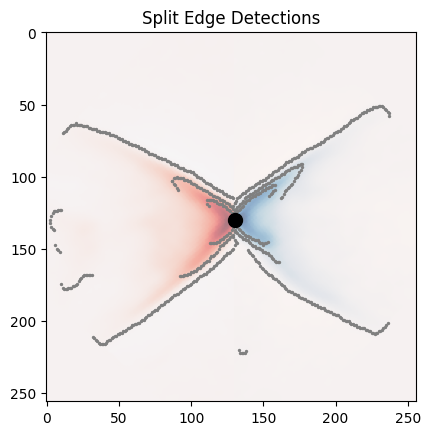

In [16]:
for idx, color in enumerate(my_star.colors):
    outflow = outflows[color]
    plt.imshow(outflow.image_rotated, alpha=1-0.5*idx, cmap=f'{color.capitalize()}s')

for idx, color in enumerate(my_star.colors):
    for idx, edge in enumerate(outflows[color].edges):
        x_top, y_top = tools._split_edge('top', edge)
        x_bot, y_bot = tools._split_edge('bot', edge)

        plt.scatter(x_top, y_top, s=2, c='grey')
        plt.scatter(x_bot, y_bot, s=2, c='grey')

plt.scatter(130, 130, s=100, c='black')
plt.title('Split Edge Detections')

The following is a automated script to trim the tails of each outflow to make it easier to select the nodes at which to combine the edge detections.

We can edit how much we want to trim by changing the values in `trim_percents`.

Text(0.5, 1.0, 'Trimmed Edges')

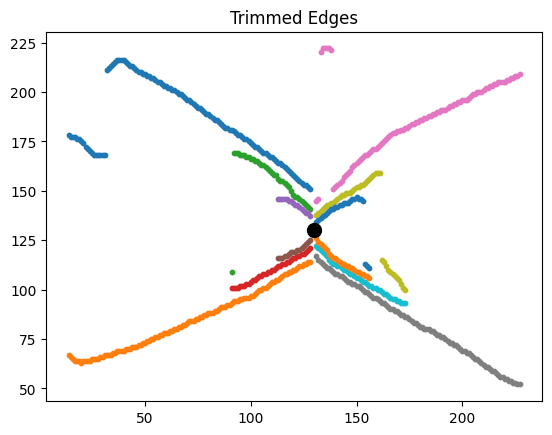

In [17]:
trim_percents = [0.1, 0.1]
for idx, color in enumerate(my_star.colors):
    x_top_array = []
    x_bot_array = []
    y_top_array = []
    y_bot_array = []

    outflow = outflows[color]
    trim_percent = trim_percents[idx]
    for idx, edge in enumerate(outflow.edges):
        x_top, y_top = tools._split_edge('top', edge)
        x_bot, y_bot = tools._split_edge('bot', edge)

        snip_top_tail_idx = int(len(x_top)*trim_percent)
        snip_bot_tail_idx = int(len(x_bot)*trim_percent)

        snip_top_head_idx = np.max(np.where(x_top < 130)) if color == 'red' else np.min(np.where(x_top > 130))
        snip_bot_head_idx = np.max(np.where(x_bot < 130)) if color == 'red' else np.min(np.where(x_bot > 130))

        x_top = x_top[snip_top_tail_idx:snip_top_head_idx] if color == 'red' else x_top[snip_top_head_idx:-snip_top_tail_idx]
        y_top = y_top[snip_top_tail_idx:snip_top_head_idx] if color == 'red' else y_top[snip_top_head_idx:-snip_top_tail_idx]
        x_bot = x_bot[snip_bot_tail_idx:snip_bot_head_idx] if color == 'red' else x_bot[snip_bot_head_idx:-snip_bot_tail_idx]
        y_bot = y_bot[snip_bot_tail_idx:snip_bot_head_idx] if color == 'red' else y_bot[snip_bot_head_idx:-snip_bot_tail_idx]

        x_top = np.append(x_top, 130)
        y_top = np.append(y_top, 130)
        x_bot = np.append(x_bot, 130)
        y_bot = np.append(y_bot, 130)

        x_top_array.append(x_top)
        y_top_array.append(y_top)
        x_bot_array.append(x_bot)
        y_bot_array.append(y_bot)

        outflow.bot_wing.edges = (x_bot_array, y_bot_array)
        outflow.top_wing.edges = (x_top_array, y_top_array)

        plt.scatter(x_top, y_top, s=10)
        plt.scatter(x_bot, y_bot, s=10)

plt.scatter(130, 130, s=100, color='black')
plt.title('Trimmed Edges')

### Selecting Combination Nodes

There are four combination nodes for each outflow and they are as follows:
1. The starting point of the loose edge detection.
2. The ending point of the loose edge detection and the start of the transitioning edge detection.
3. The ending point of the transitioning edge detection and the start of the tight edge detection.
4. The ending point of the tight edge detection.

**Note**: The nodes are in pixels and we can refer to the `Trimmed Edges` plot to determine which nodes make sense.

Text(0.5, 1.0, 'Segmented Edges')

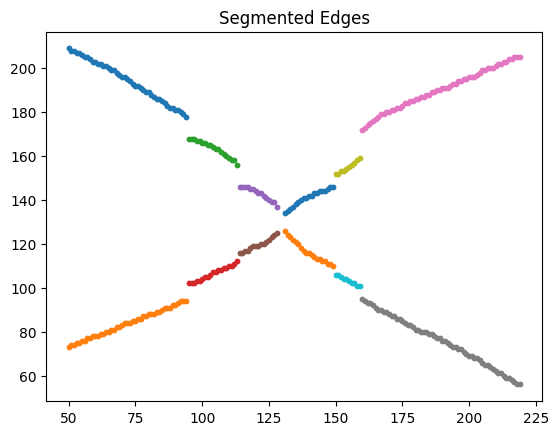

In [18]:
nodes_array = [[50, 95, 114, 130], [220, 160, 150, 130]]

for idx, color in enumerate(my_star.colors):
    outflow = outflows[color]
    x_bot_array, y_bot_array = outflow.bot_wing.edges
    x_top_array, y_top_array = outflow.top_wing.edges
    
    top_wing_x = []
    top_wing_y = []
    bot_wing_x = []
    bot_wing_y = []
    nodes = nodes_array[idx]
    for idx in range(len(outflow.edges)):
        x_bot = x_bot_array[idx]
        y_bot = y_bot_array[idx]
        x_top = x_top_array[idx]
        y_top = y_top_array[idx]

        start_top = np.min(np.where(x_top >= nodes[idx])) if color == 'red' else np.min(np.where(x_top >= nodes[idx+1]))
        end_top = np.min(np.where(x_top >= nodes[idx+1])) if color == 'red' else np.min(np.where(x_top >= nodes[idx]))

        start_bot = np.min(np.where(x_top >= nodes[idx])) if color == 'red' else np.min(np.where(x_top >= nodes[idx+1]))
        end_bot = np.min(np.where(x_top >= nodes[idx+1])) if color == 'red' else np.min(np.where(x_top >= nodes[idx]))

        x_top = x_top[start_top:end_top]
        y_top = y_top[start_top:end_top]
        x_bot = x_bot[start_bot:end_bot]
        y_bot = y_bot[start_bot:end_bot]

        top_wing_x = np.append(top_wing_x, x_top)
        top_wing_y = np.append(top_wing_y, y_top)
        bot_wing_x = np.append(bot_wing_x, x_bot)
        bot_wing_y = np.append(bot_wing_y, y_bot)

        top_wing_x = np.append(top_wing_x, 130)
        top_wing_y = np.append(top_wing_y, 130)
        bot_wing_x = np.append(bot_wing_x, 130)
        bot_wing_y = np.append(bot_wing_y, 130)

        plt.scatter(x_top, y_top, s=10)
        plt.scatter(x_bot, y_bot, s=10)

    outflow.bot_wing.combined_edges = (bot_wing_x, bot_wing_y)
    outflow.top_wing.combined_edges = (top_wing_x, top_wing_y)

#plt.scatter(130, 130)
plt.title('Segmented Edges')

The following code block combines the three edge detection segments for each wing into a single edge detection, resulting in **four final edge detections**.

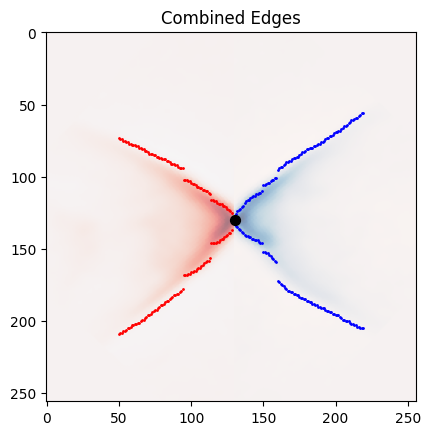

In [19]:
for color in my_star.colors:
    top_wing = outflows[color].top_wing.combined_edges
    bot_wing = outflows[color].bot_wing.combined_edges
    plt.scatter(top_wing[0], top_wing[1], s=1, c=color)
    plt.scatter(bot_wing[0], bot_wing[1], s=1, c=color)

plt.scatter(130, 130, c='black', s=50)
plt.title('Combined Edges')

for idx, color in enumerate(my_star.colors):
    outflow = outflows[color]
    plt.imshow(outflow.image_rotated, alpha=1-0.5*idx, cmap=f'{color.capitalize()}s')

# Polynomial Fit

The polynomial fit step is mostly automatic, aside from maybe adjusting the weights.

The weights can be added to improve how the polynomial is fit near the source `weights[0]` or at the extended part of the outflow wing `weights[-1]`. Usually a value of 10 will be more than enough.

## Best Polyfit

The best polyfit requires an extra step to find the best polynomial order.

This is done by calculating the reduced chi square value at every order from 1 to 10 and returning the best order with the respective smallest chi square value.

Text(0.5, 1.0, 'Best Fit Polynomial')

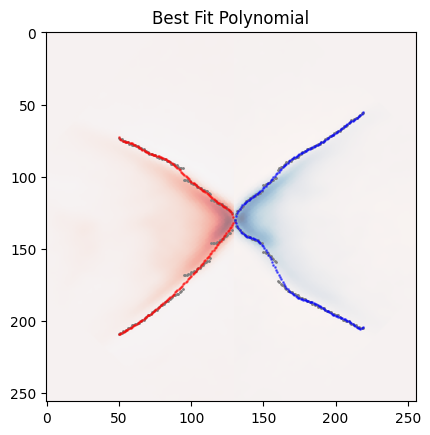

In [58]:
for color in my_star.colors:
    # TOP WING FITTING
    outflow = outflows[color]
    top_wing = outflow.top_wing
    top_edges = top_wing.combined_edges

    weights = np.ones(top_edges[0].shape)
    #weights[-1] = 10
    #weights[0] = 10

    min_chi_val, best_polyorder = tools.find_best_poly_order_fit(top_edges[0], top_edges[1], outflow.header)
    x_top_fit, y_top_fit, coeffs, top_reduced_chi_squared = tools.polynomial_fit(top_edges[0], top_edges[1], best_polyorder, weights)
    top_wing.polyBest.x_fit = x_top_fit
    top_wing.polyBest.y_fit = y_top_fit
    top_wing.polyBest.order = best_polyorder

    plt.scatter(top_edges[0], top_edges[1], s=1, c='grey')
    plt.scatter(x_top_fit, y_top_fit, alpha=0.5, s=1, c=color)


    # BOT WING FITTING
    bot_wing = outflow.bot_wing
    bot_edges = bot_wing.combined_edges
    weights = np.ones(bot_edges[0].shape)
    #weights[-1] = 10
    #weights[0] = 10

    min_chi_val, best_polyorder = tools.find_best_poly_order_fit(bot_edges[0], bot_edges[1], outflow.header)
    x_bot_fit, y_bot_fit, coeffs, bot_reduced_chi_squared = tools.polynomial_fit(bot_edges[0], bot_edges[1], best_polyorder, weights)
    bot_wing.polyBest.x_fit = x_bot_fit
    bot_wing.polyBest.y_fit = y_bot_fit
    bot_wing.polyBest.order = best_polyorder

    plt.scatter(bot_edges[0], bot_edges[1], s=1, c='grey')
    plt.scatter(x_bot_fit, y_bot_fit, alpha=0.5, s=1, c=color)

for idx, color in enumerate(my_star.colors):
    outflow = outflows[color]
    plt.imshow(outflow.image_rotated, alpha=1-0.5*idx, cmap=f'{color.capitalize()}s')

plt.title(f'Best Fit Polynomial')

## 2nd Order Polyfit

Text(0.5, 1.0, '2nd Order Polynomial Fit')

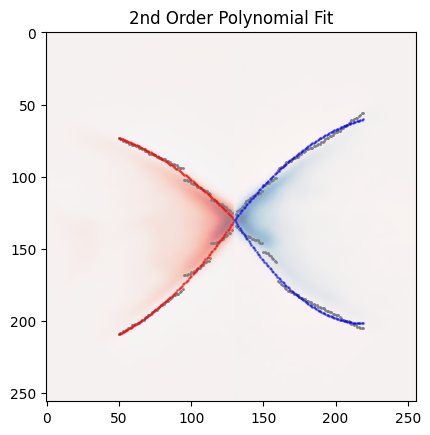

In [21]:
for color in my_star.colors:
    # TOP WING FITTING
    outflow = outflows[color]
    top_wing = outflow.top_wing
    top_edges = top_wing.combined_edges

    weights = np.ones(top_edges[0].shape)
    weights[-1] = 10
    weights[0] = 8

    x_top_fit, y_top_fit, coeffs, top_reduced_chi_squared = tools.polynomial_fit(top_edges[0], top_edges[1], 2, weights)
    top_wing.poly2.x_fit = x_top_fit
    top_wing.poly2.y_fit = y_top_fit

    plt.scatter(top_edges[0], top_edges[1], s=1, c='grey')
    plt.scatter(x_top_fit, y_top_fit, alpha=0.5, s=1, c=color)
    

    # BOT WING FITTING
    bot_wing = outflow.bot_wing
    bot_edges = bot_wing.combined_edges
    weights = np.ones(bot_edges[0].shape)
    weights[-1] = 10
    weights[0] = 8

    x_bot_fit, y_bot_fit, coeffs, bot_reduced_chi_squared = tools.polynomial_fit(bot_edges[0], bot_edges[1], 2, weights)
    bot_wing.poly2.x_fit = x_bot_fit
    bot_wing.poly2.y_fit = y_bot_fit

    plt.scatter(bot_edges[0], bot_edges[1], s=1, c='grey')
    plt.scatter(x_bot_fit, y_bot_fit, alpha=0.5, s=1, c=color)

for idx, color in enumerate(my_star.colors):
    outflow = outflows[color]
    plt.imshow(outflow.image_rotated, alpha=1-0.5*idx, cmap=f'{color.capitalize()}s')

plt.title('2nd Order Polynomial Fit')

# Calculate Opening Angle

The opening angle is calculated using the law of cosines. Which takes the linear distance from the source to each point on each polynomial of the outflow to calculate the opening angle throughout the entire length of the polynomial.

This generates a spectrum of angles determined by the distance from the source.

The code automatically adds a parameter called `angle_spectrum_distance_limit` to the Protostar object, which is the maximum distance in pixels that we allow our spectrum to go. It is the length of the shortest wing, ensuring that there is a polynomial for all angle values on the spectrum.

(0.0, 79.51569)

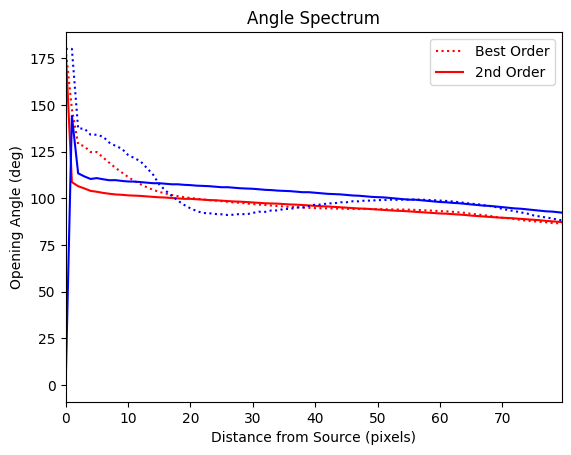

In [49]:
for color in my_star.colors:
    outflow = outflows[color]
    top_fit = [outflow.top_wing.polyBest.x_fit, outflow.top_wing.polyBest.y_fit]
    bot_fit = [outflow.bot_wing.polyBest.x_fit, outflow.bot_wing.polyBest.y_fit]
    best_angles = tools.calc_opening_angle_spectrum(top_fit, bot_fit)

    top_fit = [outflow.top_wing.poly2.x_fit, outflow.top_wing.poly2.y_fit]
    bot_fit = [outflow.bot_wing.poly2.x_fit, outflow.bot_wing.poly2.y_fit]
    order2_angles = tools.calc_opening_angle_spectrum(top_fit, bot_fit)

    outflow.angle_spectrum = {'best':best_angles, 'order2':order2_angles} # Fix to have both 2nd order and best order angle spectrums
    plt.plot(best_angles, c=color, linestyle='dotted')
    plt.plot(order2_angles, c=color)

plt.title('Angle Spectrum')
plt.legend(['Best Order', '2nd Order'])
plt.xlabel('Distance from Source (pixels)')
plt.ylabel('Opening Angle (deg)')

# Calculate the wing with the shortest length to limit the x-axis
wing_lengths = [np.abs(my_star.source_coord[0] - np.min(red.bot_wing.combined_edges[0])),
    np.abs(my_star.source_coord[0] - np.min(red.top_wing.combined_edges[0])),
    np.abs(my_star.source_coord[0] - np.max(blue.bot_wing.combined_edges[0])),
    np.abs(my_star.source_coord[0] - np.max(blue.top_wing.combined_edges[0]))]

my_star.angle_spectrum_distance_limit = np.min(wing_lengths)

plt.xlim(0, my_star.angle_spectrum_distance_limit)

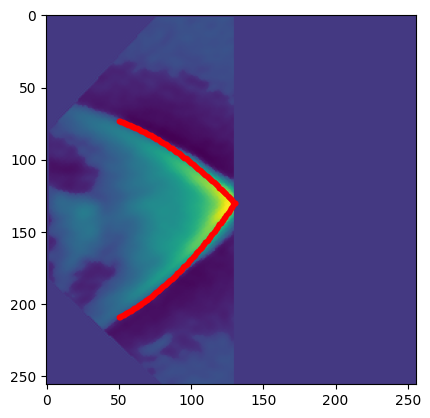

In [50]:
outflow = outflows['red']
plt.imshow(np.sign(outflow.image_rotated)*np.sqrt(np.abs(outflow.image_rotated)))
plt.scatter(outflow.top_wing.poly2.x_fit, outflow.top_wing.poly2.y_fit, c='red', s=10)
plt.scatter(outflow.bot_wing.poly2.x_fit, outflow.bot_wing.poly2.y_fit, c='red', s=10)

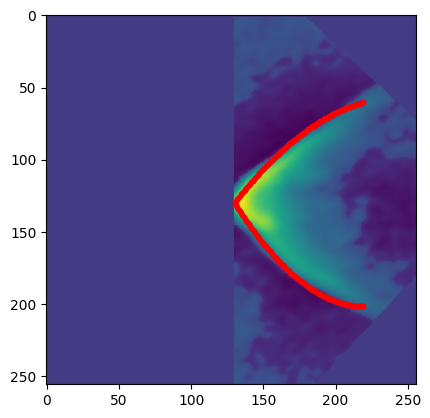

In [51]:
outflow = outflows['blue']
plt.imshow(np.sign(outflow.image_rotated)*np.sqrt(np.abs(outflow.image_rotated)))
plt.scatter(outflow.top_wing.poly2.x_fit, outflow.top_wing.poly2.y_fit, c='red', s=10)
plt.scatter(outflow.bot_wing.poly2.x_fit, outflow.bot_wing.poly2.y_fit, c='red', s=10)

# Save Protostar Object

We can save out Protostar object as a pickle file using the two line code below. The following blocks of code are the extraction code to verify that our object has been saved properly.

In [52]:
filename = f'output/{my_star.name}'
tools.save_object(my_star, filename)

(0.0, 79.51569)

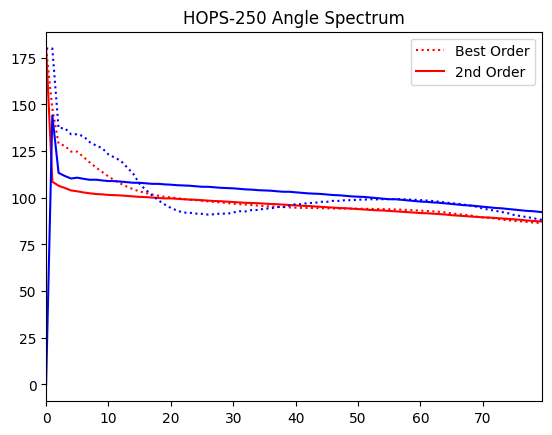

In [56]:
filename = f'output/{my_star.name}'
test_star = tools.open_pickle(filename)
plt.plot(test_star.red_shifted.angle_spectrum['best'], c='red', linestyle='dotted')
plt.plot(test_star.red_shifted.angle_spectrum['order2'], c='red')
plt.plot(test_star.blue_shifted.angle_spectrum['best'], c='blue', linestyle='dotted')
plt.plot(test_star.blue_shifted.angle_spectrum['order2'], c='blue')

plt.title(f'{my_star.name} Angle Spectrum')
plt.legend(['Best Order', '2nd Order'])
plt.xlim(0, my_star.angle_spectrum_distance_limit)

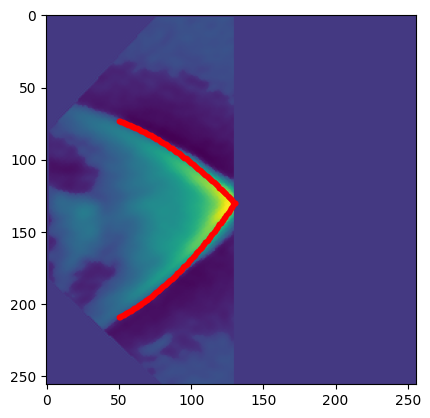

In [54]:
outflow = test_star.red_shifted
plt.imshow(np.sign(outflow.image_rotated)*np.sqrt(np.abs(outflow.image_rotated)))
plt.scatter(outflow.top_wing.poly2.x_fit, outflow.top_wing.poly2.y_fit, c='red', s=10)
plt.scatter(outflow.bot_wing.poly2.x_fit, outflow.bot_wing.poly2.y_fit, c='red', s=10)